#### Setup & Imports

In [ ]:
# ─── Cell 1: Setup environment ───────────────────────────────────────────────────
import os, sys

# Compute project root (one level up from notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add project root and src/ to Python path
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, "src"))

# Ensure required folders exist
os.makedirs(os.path.join(project_root, "logs"), exist_ok=True)
os.makedirs(os.path.join(project_root, "./reports/figures"), exist_ok=True)
os.makedirs(os.path.join(project_root, "./reports/summaries"), exist_ok=True)
os.makedirs(os.path.join(project_root, "data/interim"), exist_ok=True)
os.makedirs(os.path.join(project_root, "data/processed"), exist_ok=True)

print("Project root:", project_root)
print("Logs directory:", os.path.join(project_root, "logs"))
print("Reports directories:", os.path.join(project_root, "reports"))
print("Data interim directory:", os.path.join(project_root, "data/interim"))
print("Data processed directory:", os.path.join(project_root, "data/processed"))


Project root: /home/changomango/Documents/Personal/projects/gpu-accelerated-ensemble-stock-forecasting
Logs directory: /home/changomango/Documents/Personal/projects/gpu-accelerated-ensemble-stock-forecasting/logs
Reports directories: /home/changomango/Documents/Personal/projects/gpu-accelerated-ensemble-stock-forecasting/reports
Data interim directory: /home/changomango/Documents/Personal/projects/gpu-accelerated-ensemble-stock-forecasting/data/interim
Data processed directory: /home/changomango/Documents/Personal/projects/gpu-accelerated-ensemble-stock-forecasting/data/processed


In [31]:
# ─── Cell 2: Imports ─────────────────────────────────────────────────────────────
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook display settings
plt.rcParams.update({'figure.max_open_warning': 0})

# Import our modules
from src.features.tree_features import build_tree_features
from src.features.deep_features import create_windows
from src.decomposition.decompose import decompose_wavelet, ab_test_decomposition


In [32]:
# ─── Cell 3: Build & save tree-based features ───────────────────────────────────
# Paths
raw_path     = os.path.join(project_root, "data/raw/AAPL_2020-01-01_2025-07-31.csv")
interim_path = os.path.join(project_root, "data/interim/tree_features.csv")

# 1) Load raw OHLCV
raw = pd.read_csv(raw_path, index_col="Date", parse_dates=True)
print(f"Loaded raw OHLCV: {raw.shape[0]} rows, {raw.shape[1]} cols")

# 2) Build tree features
features = build_tree_features(raw)
print(f"Built tree features: {features.shape[0]} rows, {features.shape[1]} cols")

# 3) Save to interim/
features.to_csv(interim_path, index=True)
print(f"Saved interim features to {interim_path}")


2025-08-05 00:49:27 INFO src.features.tree_features - Starting tree feature build; input shape=(1401, 5)
2025-08-05 00:49:27 INFO src.features.tree_features - Completed tree feature build; output shape=(1382, 14)


Loaded raw OHLCV: 1401 rows, 5 cols
Built tree features: 1382 rows, 14 cols
Saved interim features to /home/changomango/Documents/Personal/projects/gpu-accelerated-ensemble-stock-forecasting/data/interim/tree_features.csv


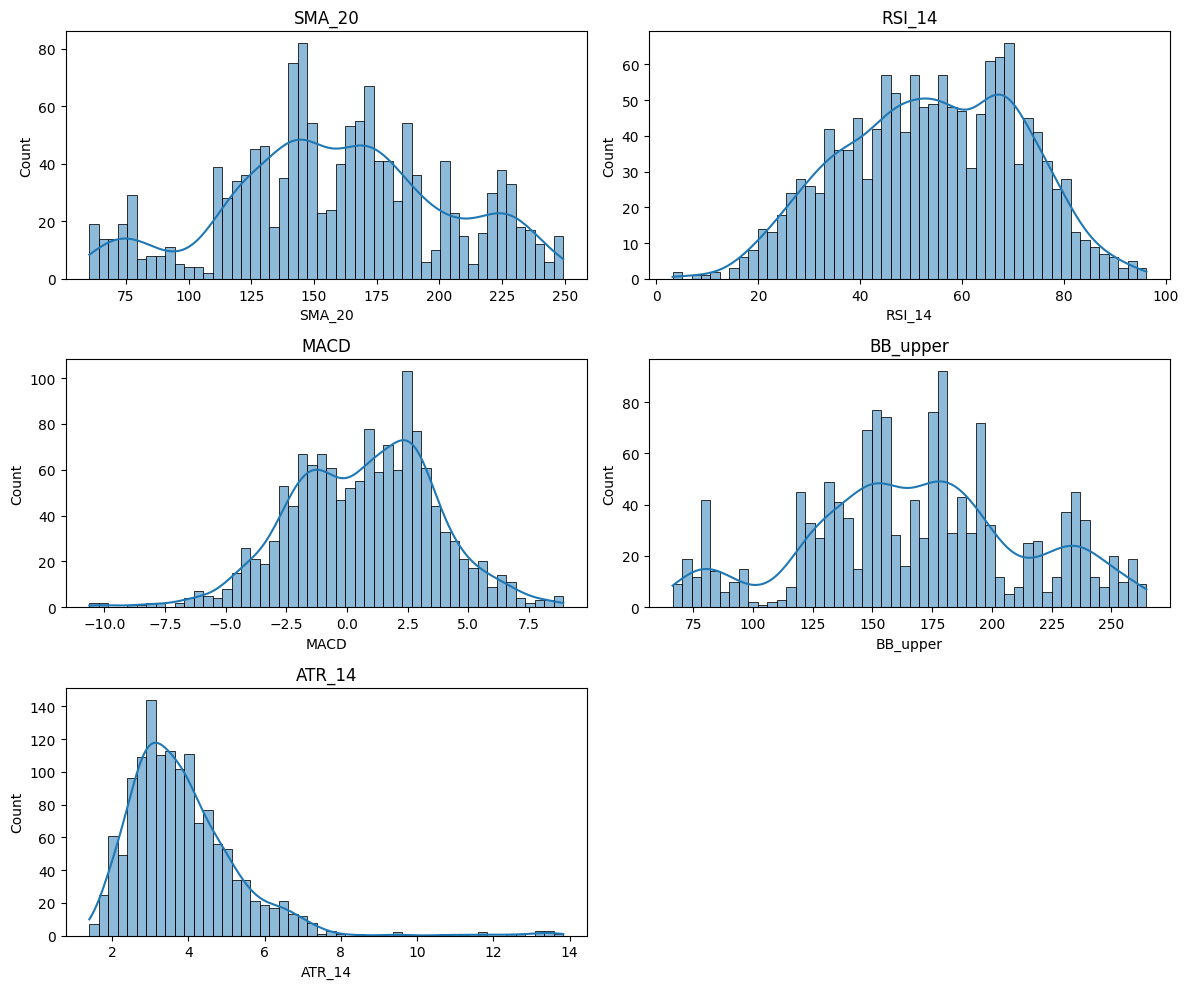

In [ ]:
# ─── Cell 5: Plot indicator distributions ────────────────────────────────────────
feat = pd.read_csv(interim_path, index_col="Date", parse_dates=True)

indicators = ["SMA_20", "RSI_14", "MACD", "BB_upper", "ATR_14"]
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, indicators):
    sns.histplot(feat[col], bins=50, kde=True, ax=ax)
    ax.set_title(col)

# Remove any unused subplot
for ax in axes[len(indicators):]:
    fig.delaxes(ax)

fig.tight_layout()
fig.savefig(os.path.join(project_root, "./reports/figures/indicator_distributions.png"), dpi=150)
plt.show()


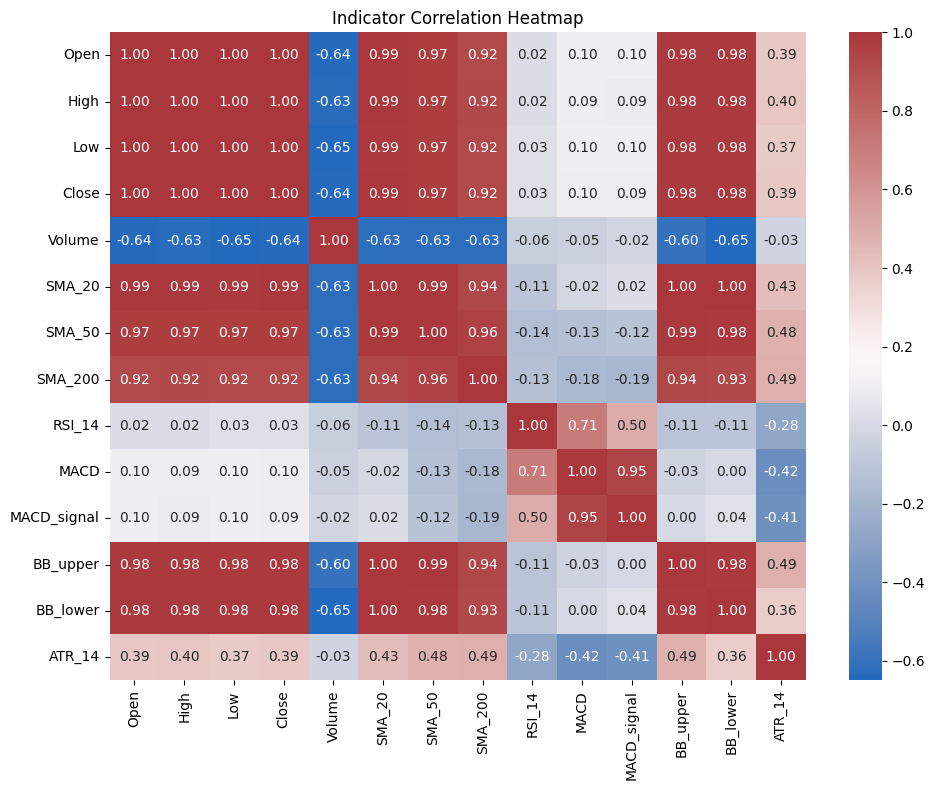

In [ ]:
# ─── Cell 6: Correlation heatmap ─────────────────────────────────────────────────
corr = feat.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Indicator Correlation Heatmap")
plt.tight_layout()
plt.savefig(os.path.join(project_root, "./reports/figures/correlation_heatmap.png"), dpi=150)
plt.show()


In [ ]:
# ─── Cell 7: Create deep-learning windows ────────────────────────────────────────
X, y = create_windows(feat, sequence_length=60)
print(f"Deep windows: X shape = {X.shape}, y shape = {y.shape}")

# Save processed arrays
np.save(os.path.join(project_root, "data/processed/X_windows.npy"), X)
np.save(os.path.join(project_root, "data/processed/y_targets.npy"), y)
print("Saved X_windows.npy and y_targets.npy")


2025-08-05 00:50:16 INFO src.features.deep_features - Creating deep windows: seq_len=60, features=['Open', 'High', 'Low', 'Close', 'Volume']
2025-08-05 00:50:16 INFO src.features.deep_features - Created windows: X=(1322, 60, 5), y=(1322,)


Deep windows: X shape = (1322, 60, 5), y shape = (1322,)
Saved X_windows.npy and y_targets.npy


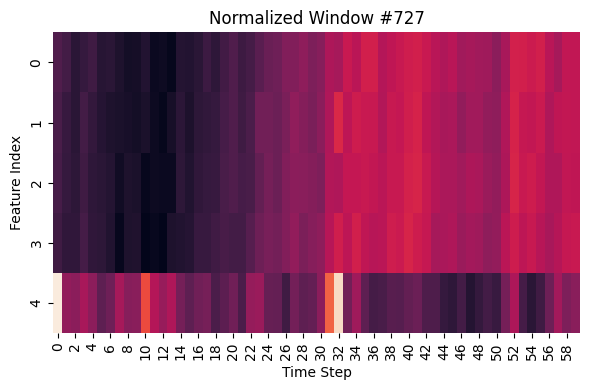

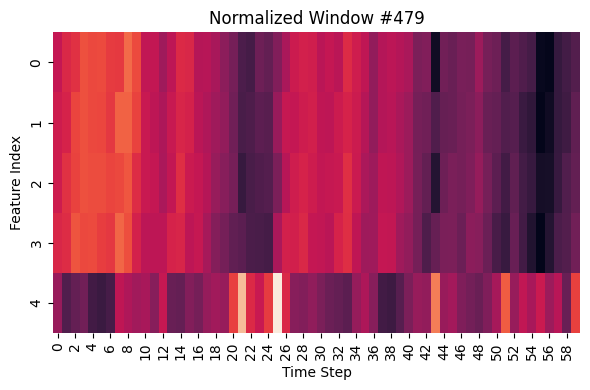

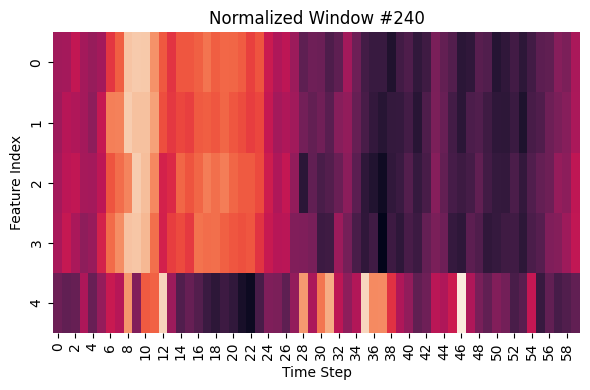

In [ ]:
# ─── Cell 8: Visualize sample windows ────────────────────────────────────────────
np.random.seed(42)
sample_idxs = np.random.choice(len(X), size=3, replace=False)

for idx in sample_idxs:
    plt.figure(figsize=(6, 4))
    sns.heatmap(X[idx].T, cbar=False)
    plt.xlabel("Time Step")
    plt.ylabel("Feature Index")
    plt.title(f"Normalized Window #{idx}")
    path = os.path.join(project_root, f"./reports/figures/window_heatmap_{idx}.png")
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.show()


2025-08-05 00:50:37 INFO src.decomposition.decompose - Starting wavelet denoising: wavelet=db4, level=3
2025-08-05 00:50:37 INFO src.decomposition.decompose - Completed wavelet denoising


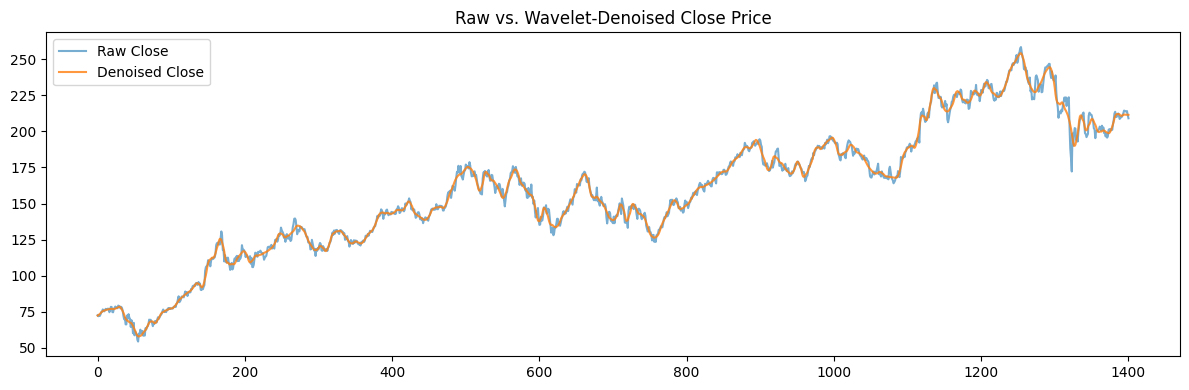

In [ ]:
# ─── Cell 9: Wavelet denoising demo ──────────────────────────────────────────────
raw_series = pd.read_csv(raw_path, index_col="Date", parse_dates=True)["Close"].to_numpy()
denoised = decompose_wavelet(raw_series, wavelet="db4", level=3)

plt.figure(figsize=(12, 4))
plt.plot(raw_series, label="Raw Close", alpha=0.6)
plt.plot(denoised, label="Denoised Close", alpha=0.8)
plt.legend()
plt.title("Raw vs. Wavelet-Denoised Close Price")
plt.tight_layout()
plt.savefig(os.path.join(project_root, "./reports/figures/raw_vs_denoised.png"), dpi=150)
plt.show()


In [ ]:
# ─── Cell 10: A/B test harness ───────────────────────────────────────────────────
def train_stub(X_train, y_train):
    class Model:
        def evaluate(self, X, y):
            # Example metric: negative MAE
            return float(-np.mean(np.abs(y - np.mean(y))))
    return Model()

results = ab_test_decomposition(raw_series, method="wavelet", model_train_fn=train_stub)
print("A/B Test Results:", results)

# Save summary CSV
pd.DataFrame([results]).to_csv(
    os.path.join(project_root, "./reports/summaries/decomposition_ab_test.csv"),
    index=False
)
print("Saved decomposition_ab_test.csv")


2025-08-05 00:50:46 INFO src.decomposition.decompose - Starting wavelet denoising: wavelet=db4, level=3
2025-08-05 00:50:46 INFO src.decomposition.decompose - Completed wavelet denoising
2025-08-05 00:50:46 INFO src.features.deep_features - Creating deep windows: seq_len=60, features=['Close']
2025-08-05 00:50:46 INFO src.features.deep_features - Created windows: X=(1341, 60, 1), y=(1341,)
2025-08-05 00:50:46 INFO src.features.deep_features - Creating deep windows: seq_len=60, features=['Close']
2025-08-05 00:50:46 INFO src.features.deep_features - Created windows: X=(1341, 60, 1), y=(1341,)
2025-08-05 00:50:46 INFO src.decomposition.decompose - A/B test complete: raw=-33.4731, denoised=-33.4199


A/B Test Results: {'raw_score': -33.47305508868513, 'denoised_score': -33.41987662737301}
Saved decomposition_ab_test.csv
